In [31]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
# --- [✨ 추가] 최종 테스트 평가 함수 ---
def evaluate_model_on_test_set(model, test_loader, device, class_names, model_path):
    """
    학습이 완료된 후 저장된 최적의 모델을 불러와
    test 데이터셋으로 최종 성능을 평가하고, 결과를 시각화합니다.
    """
    # 저장된 최적의 가중치를 모델에 로드
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()  # 모델을 평가 모드로 설정

    all_preds = []
    all_labels = []
    running_loss = 0.0
    running_corrects = 0
    criterion = nn.CrossEntropyLoss()

    print("\n--- 최종 모델 성능 평가 (Test Set) ---")
    
    with torch.no_grad(): # 그래디언트 계산 비활성화
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # 나중에 confusion matrix와 classification report를 위해 예측값과 실제값 저장
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 전체 테스트 데이터에 대한 손실과 정확도
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"\n✅ Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n")

    # --- Classification Report 출력 ---
    print("📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # --- Confusion Matrix 시각화 ---
    print("📊 Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # ✨ --- 한글 폰트 설정 시작 --- ✨
    try:
        import matplotlib.pyplot as plt
        # Windows 운영체제의 경우
        plt.rc('font', family='Malgun Gothic')
    except ImportError:
        print("matplotlib 라이브러리를 찾을 수 없습니다.")
    except Exception as e:
        print(f"폰트 설정 중 오류 발생: {e}")
        print("macOS는 'AppleGothic', Linux는 'NanumGothic'을 시도해 보세요.")

    # 마이너스 기호가 깨지는 것을 방지
    plt.rcParams['axes.unicode_minus'] = False
    # ✨ --- 한글 폰트 설정 종료 --- ✨

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=16) # 타이틀 폰트 크기 조절
    plt.xlabel('Predicted Label', fontsize=12) # x축 라벨 폰트 크기 조절
    plt.ylabel('True Label', fontsize=12) # y축 라벨 폰트 크기 조절
    plt.show()


In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, device, model_save_path):
    """EfficientNet 모델을 학습하고 검증하는 메인 함수"""
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            progress_bar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase")

            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                progress_bar.set_postfix(loss=f'{loss.item():.4f}')

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'✅ {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_save_path)
                print(f'🚀 Best validation accuracy updated: {best_acc:.4f}, Model saved!')

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model


Using device: cuda

--- 데이터셋 필터링 시작: '딸기잎흰가루병' 클래스 제외 ---
------------------------------------------------------


--- (필터링된) 데이터셋 상세 정보 ---

✅ Train Dataset: 총 2985개
  - 딸기꽃곰팡이병: 289개
  - 딸기모무늬병: 594개
  - 딸기열매흰가루병: 183개
  - 딸기잎마름병: 794개
  - 딸기잿빛곰팡이병: 682개
  - 딸기탄저병: 138개
  - 정상: 305개

✅ Val Dataset: 총 812개
  - 딸기꽃곰팡이병: 83개
  - 딸기모무늬병: 186개
  - 딸기열매흰가루병: 55개
  - 딸기잎마름병: 230개
  - 딸기잿빛곰팡이병: 176개
  - 딸기탄저병: 45개
  - 정상: 37개

✅ Test Dataset: 총 414개
  - 딸기꽃곰팡이병: 46개
  - 딸기모무늬병: 86개
  - 딸기열매흰가루병: 34개
  - 딸기잎마름병: 118개
  - 딸기잿빛곰팡이병: 88개
  - 딸기탄저병: 11개
  - 정상: 31개
---------------------------

Class names: ['딸기꽃곰팡이병', '딸기모무늬병', '딸기열매흰가루병', '딸기잎마름병', '딸기잿빛곰팡이병', '딸기탄저병', '정상']
Number of classes: 7


C:\Users\427s2\AppData\Local\Temp\ipykernel_29080\1756973827.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/15
----------


Train Phase:   0%|          | 0/94 [00:00<?, ?it/s]C:\Users\427s2\AppData\Local\Temp\ipykernel_29080\1756973827.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Train Phase: 100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=0.4403]


✅ train Loss: 0.4245 Acc: 0.8687


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.67it/s, loss=0.0001]


✅ val Loss: 0.1754 Acc: 0.9507
🚀 Best validation accuracy updated: 0.9507, Model saved!
Epoch 2/15
----------


Train Phase: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s, loss=0.2928]


✅ train Loss: 0.1858 Acc: 0.9387


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.65it/s, loss=0.0004]


✅ val Loss: nan Acc: 0.9704
🚀 Best validation accuracy updated: 0.9704, Model saved!
Epoch 3/15
----------


Train Phase: 100%|██████████| 94/94 [00:26<00:00,  3.49it/s, loss=0.3345]


✅ train Loss: 0.1567 Acc: 0.9511


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.66it/s, loss=0.0003]


✅ val Loss: 0.0773 Acc: 0.9741
🚀 Best validation accuracy updated: 0.9741, Model saved!
Epoch 4/15
----------


Train Phase: 100%|██████████| 94/94 [00:27<00:00,  3.46it/s, loss=0.4457]


✅ train Loss: 0.1177 Acc: 0.9615


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.66it/s, loss=0.0001]


✅ val Loss: 0.0674 Acc: 0.9704
Epoch 5/15
----------


Train Phase: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s, loss=0.0088]


✅ train Loss: 0.0890 Acc: 0.9715


Val Phase: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s, loss=0.0001]


✅ val Loss: 0.0700 Acc: 0.9791
🚀 Best validation accuracy updated: 0.9791, Model saved!
Epoch 6/15
----------


Train Phase: 100%|██████████| 94/94 [00:29<00:00,  3.24it/s, loss=0.1149]


✅ train Loss: 0.0997 Acc: 0.9682


Val Phase: 100%|██████████| 26/26 [00:16<00:00,  1.61it/s, loss=0.0000]


✅ val Loss: 0.0597 Acc: 0.9840
🚀 Best validation accuracy updated: 0.9840, Model saved!
Epoch 7/15
----------


Train Phase: 100%|██████████| 94/94 [00:27<00:00,  3.47it/s, loss=0.6726]


✅ train Loss: 0.0761 Acc: 0.9772


Val Phase: 100%|██████████| 26/26 [00:16<00:00,  1.61it/s, loss=0.0000]


✅ val Loss: 0.0455 Acc: 0.9852
🚀 Best validation accuracy updated: 0.9852, Model saved!
Epoch 8/15
----------


Train Phase: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s, loss=0.1446]


✅ train Loss: 0.0643 Acc: 0.9802


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.65it/s, loss=0.0000]


✅ val Loss: 0.0303 Acc: 0.9840
Epoch 9/15
----------


Train Phase: 100%|██████████| 94/94 [00:25<00:00,  3.73it/s, loss=0.9535]


✅ train Loss: 0.0466 Acc: 0.9826


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.67it/s, loss=0.0000]


✅ val Loss: 0.0254 Acc: 0.9901
🚀 Best validation accuracy updated: 0.9901, Model saved!
Epoch 10/15
----------


Train Phase: 100%|██████████| 94/94 [00:25<00:00,  3.75it/s, loss=0.0163]


✅ train Loss: 0.0371 Acc: 0.9879


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.66it/s, loss=0.0000]


✅ val Loss: 0.0246 Acc: 0.9889
Epoch 11/15
----------


Train Phase: 100%|██████████| 94/94 [00:24<00:00,  3.77it/s, loss=0.0779]


✅ train Loss: 0.0367 Acc: 0.9876


Val Phase: 100%|██████████| 26/26 [00:15<00:00,  1.65it/s, loss=0.0000]


✅ val Loss: 0.0264 Acc: 0.9889
Epoch 12/15
----------


Train Phase: 100%|██████████| 94/94 [00:24<00:00,  3.80it/s, loss=0.1796]


✅ train Loss: 0.0309 Acc: 0.9899


Val Phase: 100%|██████████| 26/26 [00:16<00:00,  1.59it/s, loss=0.0000]


✅ val Loss: 0.0305 Acc: 0.9914
🚀 Best validation accuracy updated: 0.9914, Model saved!
Epoch 13/15
----------


Train Phase: 100%|██████████| 94/94 [00:26<00:00,  3.53it/s, loss=0.0408]


✅ train Loss: 0.0359 Acc: 0.9883


Val Phase: 100%|██████████| 26/26 [00:16<00:00,  1.62it/s, loss=0.0000]


✅ val Loss: 0.0329 Acc: 0.9889
Epoch 14/15
----------


Train Phase: 100%|██████████| 94/94 [00:27<00:00,  3.40it/s, loss=0.0033]


✅ train Loss: 0.0319 Acc: 0.9886


Val Phase: 100%|██████████| 26/26 [00:16<00:00,  1.58it/s, loss=0.0000]


✅ val Loss: 0.0322 Acc: 0.9889
Epoch 15/15
----------


Train Phase: 100%|██████████| 94/94 [00:26<00:00,  3.50it/s, loss=0.0010]


✅ train Loss: 0.0376 Acc: 0.9879


Val Phase: 100%|██████████| 26/26 [00:16<00:00,  1.60it/s, loss=0.0000]


✅ val Loss: 0.0273 Acc: 0.9901

Training complete in 10m 43s
🏆 Best val Acc: 0.991379

--- 최종 모델 성능 평가 (Test Set) ---


Testing: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


✅ Test Loss: 0.0549 | Test Acc: 0.9855

📋 Classification Report:
              precision    recall  f1-score   support

     딸기꽃곰팡이병     1.0000    1.0000    1.0000        46
      딸기모무늬병     0.9885    1.0000    0.9942        86
    딸기열매흰가루병     0.9143    0.9412    0.9275        34
      딸기잎마름병     1.0000    0.9915    0.9957       118
    딸기잿빛곰팡이병     0.9773    0.9773    0.9773        88
       딸기탄저병     1.0000    1.0000    1.0000        11
          정상     1.0000    0.9677    0.9836        31

    accuracy                         0.9855       414
   macro avg     0.9829    0.9825    0.9826       414
weighted avg     0.9857    0.9855    0.9856       414

📊 Confusion Matrix:


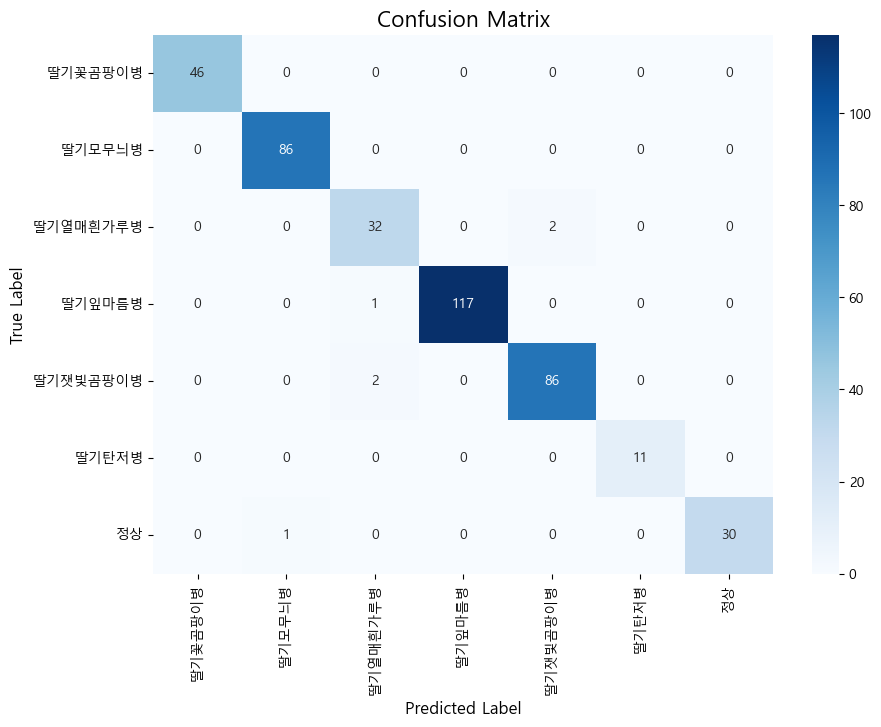

In [34]:
if __name__ == '__main__':
    # --- 1. 설정 및 하이퍼파라미터 ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    DATA_PATH = r'C:\Users\427s2\KSEB\strawberry\effinet_811_dataset'
    MODEL_SAVE_PATH = 'no_powdery_leaf_strawberry_classifier.pth'
    
    IMG_SIZE = 240
    BATCH_SIZE = 32
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.001
    CLASS_TO_EXCLUDE = '딸기잎흰가루병' # 제외할 클래스 이름

    # --- 2. 데이터 전처리 및 로더 준비 ---
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x])
                    for x in ['train', 'val', 'test']}
    
    # ==================================================================
    # ✨ [수정된 부분] 특정 클래스 제외 로직
    print(f"\n--- 데이터셋 필터링 시작: '{CLASS_TO_EXCLUDE}' 클래스 제외 ---")
    
    for split in ['train', 'val', 'test']:
        dataset = image_datasets[split]
        
        # 1. 제외할 클래스의 인덱스 찾기
        if CLASS_TO_EXCLUDE not in dataset.class_to_idx:
            print(f"'{CLASS_TO_EXCLUDE}' 클래스를 {split} 데이터셋에서 찾을 수 없습니다. 건너뜁니다.")
            continue
            
        exclude_idx = dataset.class_to_idx[CLASS_TO_EXCLUDE]

        # 2. 해당 클래스를 제외한 샘플(이미지 경로, 레이블)만 필터링
        original_samples = dataset.samples
        filtered_samples = [s for s in original_samples if s[1] != exclude_idx]
        
        # 3. 클래스 목록과 class_to_idx 딕셔너리 재구성
        new_classes = [c for c in dataset.classes if c != CLASS_TO_EXCLUDE]
        new_class_to_idx = {cls_name: i for i, cls_name in enumerate(new_classes)}
        
        # 4. 필터링된 샘플들의 레이블을 새로운 인덱스(0, 1, 2...)로 재매핑
        #    예: [0, 2, 3] -> [0, 1, 2]
        remapped_samples = []
        for path, old_idx in filtered_samples:
            old_class_name = dataset.classes[old_idx]
            new_idx = new_class_to_idx[old_class_name]
            remapped_samples.append((path, new_idx))

        # 5. 데이터셋 객체의 속성을 갱신
        dataset.samples = remapped_samples
        dataset.imgs = remapped_samples
        dataset.classes = new_classes
        dataset.class_to_idx = new_class_to_idx
        dataset.targets = [s[1] for s in remapped_samples]

    print("------------------------------------------------------\n")
    # ==================================================================
    
    # ==================================================================
    # ✨ [추가된 부분] 데이터셋 상세 정보 출력
    print("\n--- (필터링된) 데이터셋 상세 정보 ---")
    for split in ['train', 'val', 'test']:
        dataset = image_datasets[split]
        class_names_list = dataset.classes
        class_counts = {class_name: 0 for class_name in class_names_list}
        for _, label_idx in dataset.samples:
            class_name = class_names_list[label_idx]
            class_counts[class_name] += 1
        
        print(f"\n✅ {split.capitalize()} Dataset: 총 {len(dataset)}개")
        # 클래스 이름 순서가 폴더 순서에 따라 달라질 수 있으므로, 정렬해서 출력
        for class_name in sorted(class_counts.keys()):
            print(f"  - {class_name}: {class_counts[class_name]}개")
    print("---------------------------\n")
    # ==================================================================

    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
        'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
        'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    }
    
    class_names = image_datasets['train'].classes
    NUM_CLASSES = len(class_names)
    print("Class names:", class_names)
    print(f"Number of classes: {NUM_CLASSES}")

    # --- 3. 모델 준비 ---
    model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(DEVICE)

    # --- 4. 손실 함수, 옵티마이저, 스케줄러 정의 ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # --- 5. 모델 학습 시작 ---
    trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                                num_epochs=NUM_EPOCHS, 
                                dataloaders={'train': dataloaders['train'], 'val': dataloaders['val']}, 
                                device=DEVICE, 
                                model_save_path=MODEL_SAVE_PATH)

    # --- 6. 학습 완료 후 Test Set으로 최종 평가 ---
    evaluate_model_on_test_set(model=trained_model, 
                            test_loader=dataloaders['test'], 
                            device=DEVICE, 
                            class_names=class_names,
                            model_path=MODEL_SAVE_PATH)

In [63]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import json

def predict_image(model_path, image_path, class_names, device):
    """
    학습된 모델을 로드하여 단일 이미지의 클래스를 예측합니다.

    Args:
        model_path (str): 저장된 모델 파일(.pth)의 경로
        image_path (str): 테스트할 이미지 파일의 경로
        class_names (list): 학습 시 사용된 클래스 이름 리스트
        device (torch.device): 연산을 수행할 장치 (cpu 또는 cuda)

    Returns:
        tuple: (예측된 클래스 이름, 신뢰도 확률)
    """
    # 1. 모델 아키텍처 불러오기 및 최종 레이어 수정
    num_classes = len(class_names)
    model = models.efficientnet_b1(weights=None) # 사전학습 가중치는 사용 안 함
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

    # 2. 학습된 가중치(state_dict) 로드
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # 모델을 평가 모드로 설정 (dropout, batchnorm 비활성화)

    # 3. 이미지 전처리 (학습 시 validation 단계와 동일하게)
    preprocess = transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(240),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device) # 배치 차원 추가
    except FileNotFoundError:
        return f"오류: '{image_path}' 파일을 찾을 수 없습니다.", 0.0

    # 4. 예측 수행
    with torch.no_grad(): # 그래디언트 계산 비활성화
        outputs = model(image_tensor)
        # Softmax를 적용하여 확률로 변환
        probabilities = F.softmax(outputs, dim=1)
        # 가장 높은 확률과 해당 인덱스 가져오기
        confidence, predicted_idx = torch.max(probabilities, 1)

    # 5. 결과 반환
    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    return predicted_class, confidence_score


if __name__ == '__main__':
    # --- 설정 ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 📂 학습된 모델 파일 경로
    MODEL_PATH = r'C:\Users\427s2\KSEB\strawberry\no_powdery_leaf_strawberry_classifier.pth'
    
    # 🖼️ 테스트하고 싶은 이미지 파일 경로 (이 부분을 수정하세요!)
    IMAGE_TO_TEST = r'C:\Users\427s2\KSEB\strawberry\test_data\딸기꽃곰팡이병3.jpg' 
    
    # ❗ 클래스 이름 (train.py에서 사용한 순서와 반드시 동일해야 함)
    CLASS_NAMES = ['딸기꽃곰팡이병', '딸기모무늬병', '딸기열매흰가루병', '딸기잎마름병', '딸기잿빛곰팡이병', '딸기탄저병', '정상']  # 딸기잎흰가루병 제외
    
    # --- 예측 실행 ---
    predicted_class, confidence = predict_image(MODEL_PATH, IMAGE_TO_TEST, CLASS_NAMES, DEVICE)
    
    if "오류" in predicted_class:
        print(predicted_class)
    else:
        print("\n--- 예측 결과 ---")
        print(f"✅ 이미지: {IMAGE_TO_TEST}")
        print(f"🔍 예측된 클래스: **{predicted_class}**")
        print(f"🎯 신뢰도: **{confidence:.2f}%**")


--- 예측 결과 ---
✅ 이미지: C:\Users\427s2\KSEB\strawberry\test_data\딸기꽃곰팡이병3.jpg
🔍 예측된 클래스: **딸기꽃곰팡이병**
🎯 신뢰도: **94.11%**
